In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Add, Activation
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
import tensorflow as tf
%matplotlib inline

In [60]:
# Load the dataset
file_path = "./UAVNet-Defense Comprehensive UAV Network Traffic Dataset.csv"
df = pd.read_csv(file_path)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42795 entries, 0 to 42794
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FlowID           42795 non-null  int64  
 1   FlowDuration/s   42795 non-null  float64
 2   SrcAddr          42795 non-null  object 
 3   SrcPort          42795 non-null  int64  
 4   DstAddr          42795 non-null  object 
 5   DstPort          42795 non-null  int64  
 6   Protocol         42795 non-null  object 
 7   TxPackets        42795 non-null  int64  
 8   RxPackets        42795 non-null  int64  
 9   LostPackets      42795 non-null  int64  
 10  TxBytes          42795 non-null  int64  
 11  RxBytes          42795 non-null  int64  
 12  TxPacketRate/s   42795 non-null  float64
 13  RxPacketRate/s   42795 non-null  float64
 14  TxByteRate/s     42795 non-null  float64
 15  RxByteRate/s     42795 non-null  float64
 16  MeanDelay/s      42795 non-null  float64
 17  MeanJitter/s

In [11]:
# Encode 'Protocol' and 'label'
protocol_encoder = LabelEncoder()
df["Protocol"] = protocol_encoder.fit_transform(df["Protocol"])
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])
print("\nLabel Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Label Mapping: {'AODV Attack': 0, 'Flooding Attack': 1, 'Legitimate AODV Traffic': 2, 'Normal Traffic': 3, 'Sybil Attack': 4}


In [12]:
# Define feature columns and label column
feature_columns = [
    "FlowDuration/s", "SrcPort", "DstPort", "Protocol",
    "TxPackets", "RxPackets", "LostPackets", "TxBytes", "RxBytes",
    "TxPacketRate/s", "RxPacketRate/s", "TxByteRate/s", "RxByteRate/s",
    "MeanDelay/s", "MeanJitter/s", "Throughput/Kbps",
    "MeanPacketSize", "PacketDropRate", "AverageHopCount"
]
label_column = "label"

In [13]:
scaler = RobustScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

In [14]:
# Split the data
X = df[feature_columns].values
y = df[label_column].values

In [15]:
X = X.reshape((X.shape[0], X.shape[1], 1))
y = to_categorical(y)
n_classes = y.shape[1]

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 34236, Testing samples: 8559


In [17]:
# Define the CNN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("\nCNN Model Summary:")
model.summary()


CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 17, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,013 (74.27 KB)

 Trainable params: 19,013 (74.27 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/25
856/856 - 4s - 5ms/step - accuracy: 0.8119 - loss: 1.2322 - val_accuracy: 0.8822 - val_loss: 0.4074
Epoch 2/25
856/856 - 2s - 3ms/step - accuracy: 0.8702 - loss: 0.4830 - val_accuracy: 0.8879 - val_loss: 0.3325
Epoch 3/25
856/856 - 3s - 3ms/step - accuracy: 0.8831 - loss: 0.3802 - val_accuracy: 0.8900 - val_loss: 0.3111
Epoch 4/25
856/856 - 2s - 3ms/step - accuracy: 0.8863 - loss: 0.3384 - val_accuracy: 0.8912 - val_loss: 0.2923
Epoch 5/25
856/856 - 3s - 3ms/step - accuracy: 0.8887 - loss: 0.3274 - val_accuracy: 0.8919 - val_loss: 0.2914
Epoch 6/25
856/856 - 3s - 3ms/step - accuracy: 0.8905 - loss: 0.3230 - val_accuracy: 0.8918 - val_loss: 0.2831
Epoch 7/25
856/856 - 2s - 3ms/step - accuracy: 0.8918 - loss: 0.3013 - val_accuracy: 0.8969 - val_loss: 0.2832
Epoch 8/25
856/856 - 2s - 3ms/step - accuracy: 0.8957 - loss: 0.2917 - val_accuracy: 0.8965 - val_loss: 0.2680
Epoch 9/25
856/856 - 2s - 3ms/step - accuracy: 0.8951 - loss: 0.2876 - val_accuracy: 0.8966 - val_loss: 0.2565
E

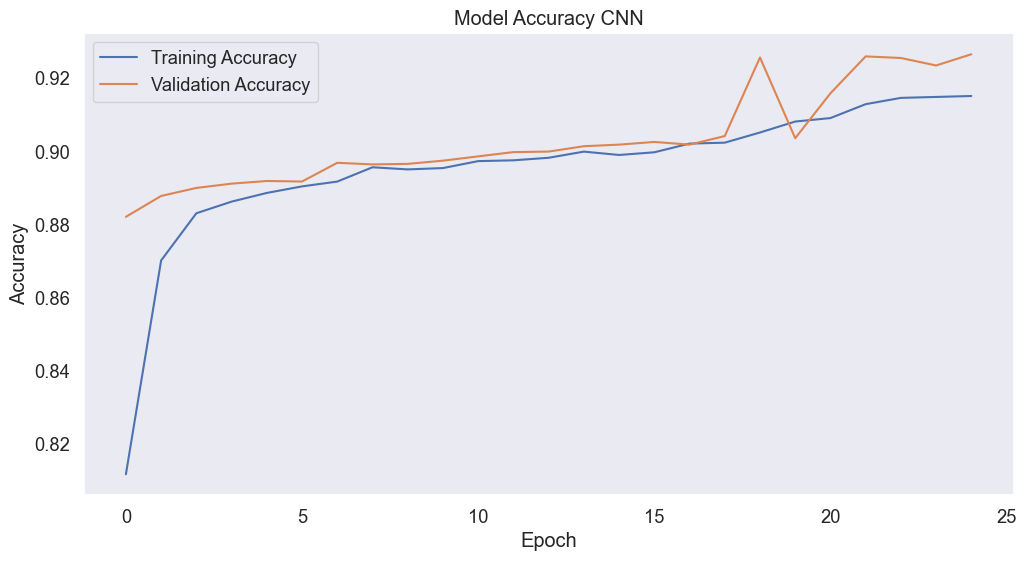

In [54]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("cnn_model_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

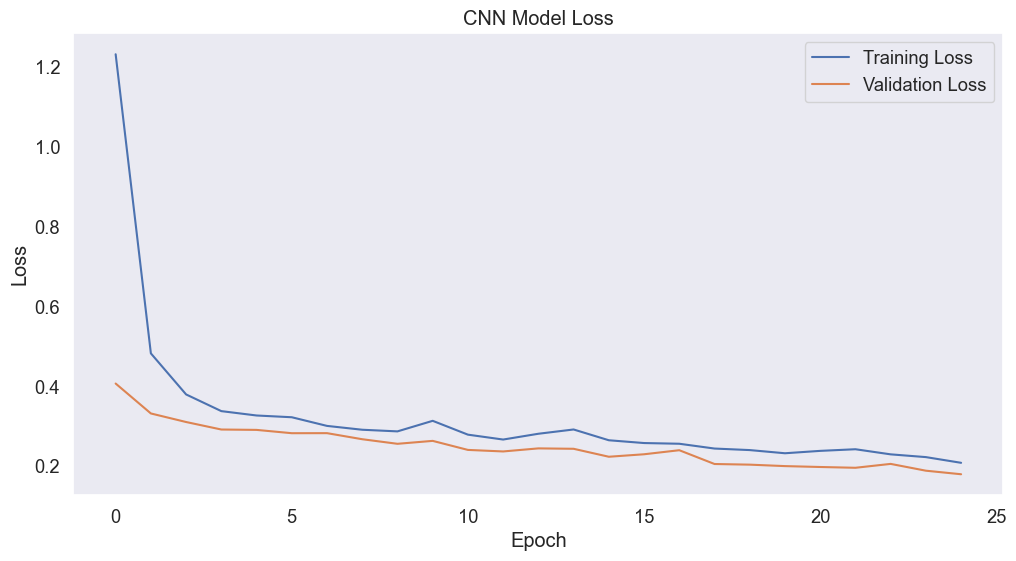

In [58]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("cnn_model_loss.png", dpi=300)
plt.show()

In [22]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [23]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))


Classification Report:
                         precision    recall  f1-score   support

            AODV Attack       0.93      0.87      0.90      1813
        Flooding Attack       0.55      0.88      0.67       194
Legitimate AODV Traffic       0.96      0.98      0.97      5155
         Normal Traffic       0.92      1.00      0.96      1150
           Sybil Attack       0.97      0.15      0.25       247

               accuracy                           0.93      8559
              macro avg       0.87      0.77      0.75      8559
           weighted avg       0.94      0.93      0.92      8559



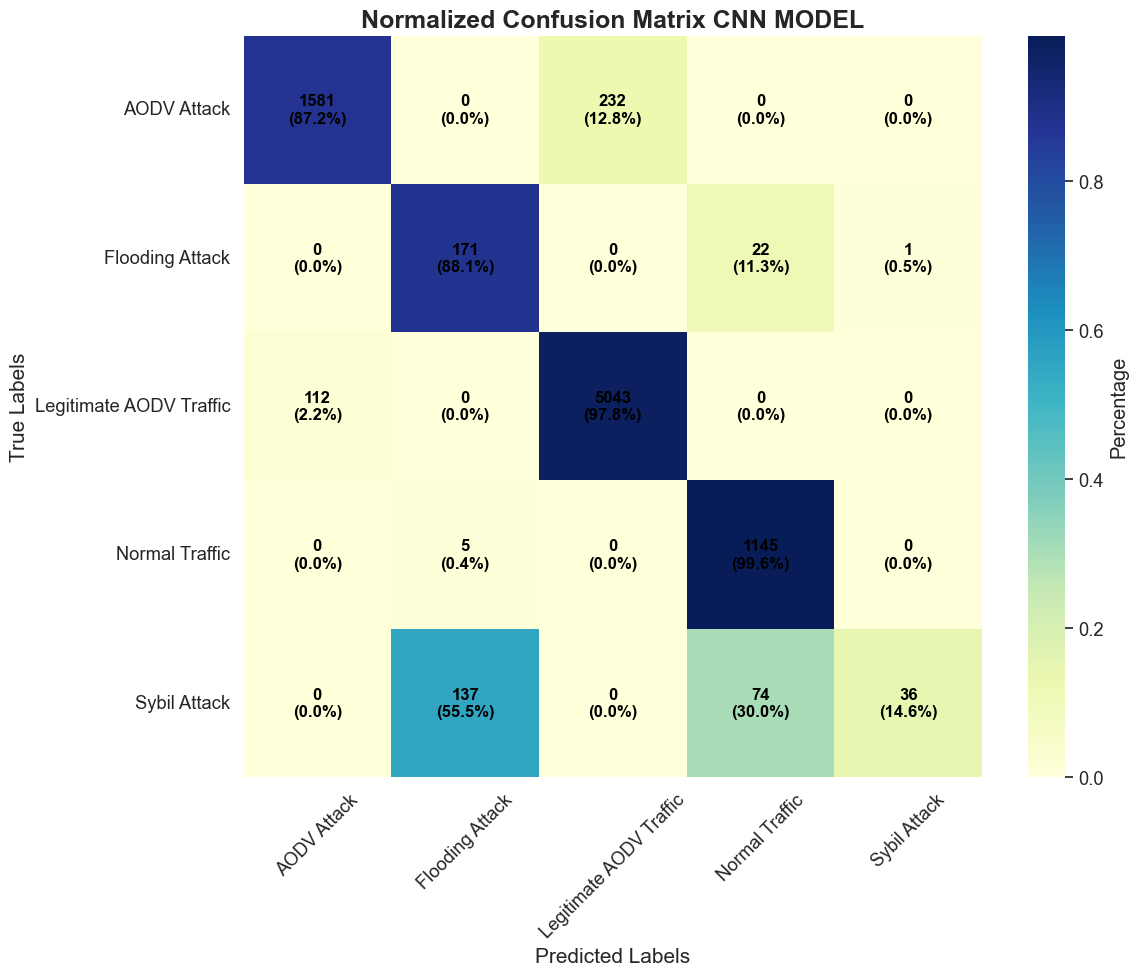

In [48]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Normalize the confusion matrix by row (true labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create the plot
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)

# Plot the heatmap with normalized values
heatmap = sns.heatmap(conf_matrix_normalized, annot=False, cmap='YlGnBu', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar_kws={'label': 'Percentage'})

# Annotate each cell with the raw count and normalized percentage
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        percentage = conf_matrix_normalized[i, j] * 100
        heatmap.text(j + 0.5, i + 0.5, f"{count}\n({percentage:.1f}%)", ha='center', va='center', color="black", fontsize=12, fontweight='bold')

# Set titles and labels
plt.title("Normalized Confusion Matrix CNN MODEL", fontsize=18, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=15)
plt.ylabel("True Labels", fontsize=15)

# Adjust layout and show the plot
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("normalized_confusion_matrix_cnn_model.png", dpi=300, bbox_inches='tight')
plt.show()

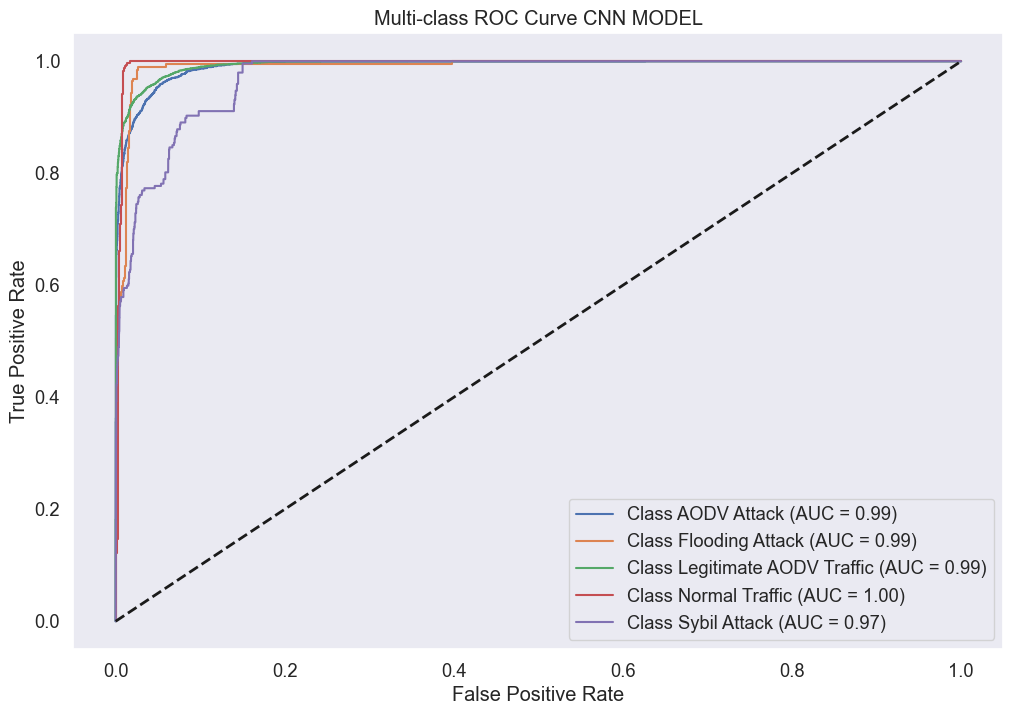

In [52]:
# ROC Curve
y_test_binarized = label_binarize(y_test_classes, classes=np.unique(y_test_classes))
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Multi-class ROC Curve CNN MODEL")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("multi-class_roc_curve_cnn_model.png", dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Save the trained CNN model
model.save("cnn_uav_traffic_model.keras")
print("\nModel saved as 'cnn_uav_traffic_model.keras'")


Model saved as 'cnn_uav_traffic_model.keras'
